In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import matplotlib.pyplot as plt

from HNL_MC import *

from particle import literals as lp

In [64]:
main_folder = 'nd280-heavy-neutrino-search-2018_main/'
flux_filename = 'flux.npy'
eff_filename = 'efficiency.npy'

In [88]:
flux = np.load(main_folder+flux_filename)
flux[:, 10] /= 2
flux[:, 34] /= 2
eff = np.load(main_folder+eff_filename)

nd280_limits_prof = np.loadtxt(main_folder + 'limits_combined/limits_profiling.dat')

In [67]:
masses_t2k = np.linspace(140, 490, 36)
masses_all = np.linspace(10, 490, 49)

In [68]:
channels = [r'$\mu\pi$',
            r'$e^-\pi^+$',
            r'$e^+\pi^-$',
            r'$mu^+\mu^-$',
            r'$e^+e^-$',]

stop_index_fit = 14

eff_fit = np.zeros(shape=(len(masses_all), 24, 10))

Text(0.5, 1.0, '$\\bar{\\nu}$ mode - Only $K \\rightarrow \\mu N \\rightarrow \\mu(e^+e^-\\nu_\\mu)$')

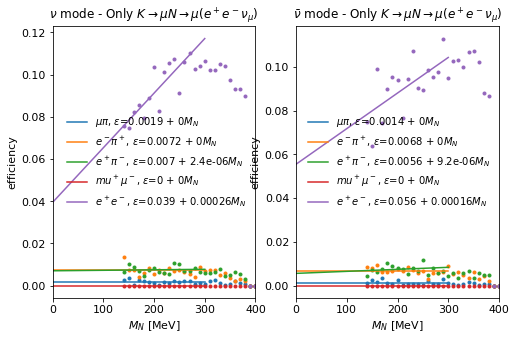

In [69]:
mode = 10
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].plot(masses_t2k, eff[:, mode, :5], '.')
axs[1].plot(masses_t2k, eff[:, mode, 5:], '.')

for i in range(10):
    if i < 5:
        this_ax = axs[0]
    else:
        this_ax = axs[1]
    poly = np.polynomial.polynomial.Polynomial.fit(masses_t2k[:stop_index_fit], 
                                                   eff[:stop_index_fit, mode, i], 
                                                   deg=1)
    if (poly(1)-poly(0)) < 0:
        poly = np.polynomial.polynomial.Polynomial.fit(masses_t2k[:stop_index_fit], 
                                                       eff[:stop_index_fit, mode, i], 
                                                       deg=0)
    this_ax.plot(np.linspace(0, 300, 15), 
                 poly(np.linspace(0, 300, 15)), 
                 label=f'{channels[i%5]}, $\epsilon$={poly(0):.2g} + {(poly(1)-poly(0)):.2g}$M_N$',
                 color=f'C{i%5}')

    eff_fit[:, mode, i] = poly(masses_all)

for i in range(2):
    axs[i].set_xlim(0, 400)
    axs[i].set_xlabel(r'$M_N$ [MeV]')
    axs[i].set_ylabel('efficiency')
    axs[i].legend(frameon=False)
axs[0].set_title(r'$\nu$ mode - Only $K \rightarrow \mu N \rightarrow \mu(e^+e^-\nu_\mu)$')
axs[1].set_title(r'$\bar{\nu}$ mode - Only $K \rightarrow \mu N \rightarrow \mu(e^+e^-\nu_\mu)$')

In [105]:
nd280fhc = exp.experiment(exp.ND280_FHC)
USQR = 1e-10
hnl_rate_nuee = []
for mass in masses_all:
    hnl_rate_nuee.append(hnl_tools.get_event_rate_mode((mass/1000, USQR), 
                                                       flavor_struct=[0.0, 1, 0.0], 
                                                       exp_setup=exp.ND280_FHC,
                                                       modes=['nu_e_e']))
    
hnl_rate_nuee = np.squeeze(np.asarray(hnl_rate_nuee))/USQR**2

In [106]:
flux_fit = np.zeros((len(masses_all), flux.shape[1]))
flux_fit[:, 10] = hnl_rate_nuee

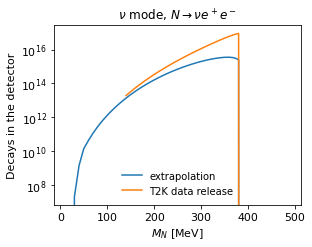

In [107]:
plt.plot(masses_all, flux_fit[:, 10], label='extrapolation')
plt.plot(masses_t2k, flux[:, 10], label='T2K data release')
plt.xlabel(r'$M_N$ [MeV]')
plt.ylabel(r'Decays in the detector')
plt.title(r'$\nu$ mode, $N \rightarrow \nu e^+e^-$')
plt.yscale('log')
plt.legend(frameon=False)

In [73]:
flux_fit[13:, 10]/flux[:, 10]

<ipython-input-73-bfdecbef521e>:1: RuntimeWarning: invalid value encountered in true_divide
  flux_fit[13:, 10]/flux[:, 10]


array([0.70686763, 0.66753177, 0.62848671, 0.59048429, 0.55244272,
       0.51530605, 0.47885837, 0.44376625, 0.40917732, 0.37543782,
       0.34318977, 0.31224314, 0.28256283, 0.25329935, 0.226095  ,
       0.19978121, 0.17541515, 0.15196436, 0.13019416, 0.10996358,
       0.09117698, 0.07415656, 0.05846392, 0.04370654, 0.02840574,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [74]:
#Bayesian limit with flat prior
from scipy.special import erf, erfinv
def bayesian_upper_limit(n_events, cl=0.9):
    eta = np.sqrt(n_events)
    return erfinv(cl * erf(eta)) / eta

def n_events_T2K(eff, flux, channels=range(10), modes=[0, 4, 10, 12, 18, 22]):
    channels = np.asarray(channels)
    modes = np.asarray(modes)
    nu_channels = channels[channels<5]
    antinu_channels = channels[channels>=5]
    n_events = 0
    if len(nu_channels)>0:
        n_events += eff[:, modes, :][:, :, nu_channels] * flux[:, modes, np.newaxis]
    if len(antinu_channels)>0:
        n_events += eff[:, modes, :][:, :, antinu_channels] * flux[:, modes+24, np.newaxis]
    return n_events

In [75]:
nev_official = n_events_T2K(eff, 
                            flux, 
                            channels=range(5), 
                            modes=[10]).sum(axis=-1)
nev_extended = n_events_T2K(eff_fit, 
                            flux_fit, 
                            channels=range(5), 
                            modes=[10]).sum(axis=-1)

official_limit = bayesian_upper_limit(nev_official)
extended_limit = bayesian_upper_limit(nev_extended)

<ipython-input-74-6ead2493b37d>:5: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta


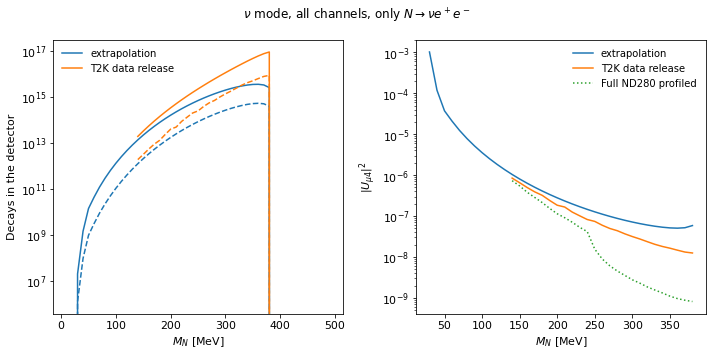

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(r'$\nu$ mode, all channels, only $N \rightarrow \nu e^+e^-$')

axs[0].plot(masses_all, flux_fit[:, 10], 'C0-', label='extrapolation')
axs[0].plot(masses_all, nev_extended, 'C0--')
axs[0].plot(masses_t2k, flux[:, 10], 'C1-', label='T2K data release')
axs[0].plot(masses_t2k, nev_official, 'C1--')
axs[0].set_xlabel(r'$M_N$ [MeV]')
axs[0].set_ylabel(r'Decays in the detector')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)

axs[1].plot(masses_all, extended_limit, 'C0', label='extrapolation')
axs[1].plot(masses_t2k, official_limit, 'C1', label='T2K data release')
axs[1].plot(nd280_limits_prof[:-11, 0], nd280_limits_prof[:-11, 2], 'C2', linestyle='dotted', 
            label='Full ND280 profiled')
axs[1].set_xlabel(r'$M_N$ [MeV]')
axs[1].set_ylabel(r'$|U_{\mu 4}|^2$')
axs[1].set_yscale('log')
axs[1].legend(frameon=False)

plt.tight_layout()